Notebook to analyze and generate table / figures in VivaBench paper

In [2]:
import pandas as pd
import os

In [19]:
grok = pd.read_csv('metrics_output/grok.csv')
deepseek = pd.read_csv('metrics_output/deepseek.csv')
llama = pd.read_csv('metrics_output/llama.csv')
o4mini = pd.read_csv('metrics_output/o4mini.csv')
gemini = pd.read_csv('metrics_output/gemini.csv')
qwen = pd.read_csv('metrics_output/qwen.csv')

all_results = dict(gemini=gemini,
deepseek=deepseek,
o4mini=o4mini,
llama=llama,
grok=grok,
qwen=qwen,)


In [20]:
model_colors = {
    'gemini': '#245501',    # Google green
    'deepseek': '#00377e',  # Bright blue
    'o4mini': '#39b89a',       # Teal/cyan
    'llama': '#ff006d',     # Pink
    'grok': '#8f00ff',      # Purple
    'qwen': '#ff7d00'       # Orange
}

model_name = {'gemini': "Gemini 2.5 Pro", 
'deepseek': "DeepSeek-R1", 
'o4mini': "o4-mini", 
'llama': "Llama-4 Maverick", 
'grok': "Grok 3 Mini Beta", 
'qwen': "Qwen 3 (235b-a22b)",}


In [21]:
ds = pd.read_csv('hf/dataset/dataset_reviewed.csv')
ds.specialty_group.value_counts()

specialty_group
Endocrine & Reproductive           150
Infectious Disease & Immunology    150
Cardiovascular & Metabolic         148
Gastrointestinal                   147
Neurological / Psychiatric         136
Hematology / Oncology / Other      112
Pediatric                           69
Respiratory                         51
Musculoskeletal & Pain              26
Gynecological / Reproductive         1
Name: count, dtype: int64

In [22]:
# Intersecting cases
uids = set(grok.uid).intersection(set(deepseek.uid)).intersection(set(llama.uid)).intersection(set(gemini.uid)).intersection(set(qwen.uid)).intersection(set(o4mini.uid))
uids = list(uids)
len(uids)

934

In [23]:
ds = pd.read_csv('hf/dataset/dataset_reviewed.csv')
ds['uid'] = ds.uid.apply(lambda x: int(x.replace("pbm_", "")))
ds = ds[ds.uid.isin(uids)]
ds = ds.set_index('uid')


In [24]:
for k, df in all_results.items():
    all_results[k] = df[df.uid.isin(uids)].set_index('uid')

In [35]:
sum_stats = pd.DataFrame({k: df.mean(numeric_only=True) for k, df in all_results.items()}).T

In [28]:
# Token count
all_s = []
for k, df in all_results.items():
    all_s.append(df.agent_token_usage.sum())
    print(f"{model_name[k]} & {df.agent_token_usage.sum() / 1000000} & {int(df.agent_token_usage.mean())}±{int(df.agent_token_usage.std())}")

Gemini 2.5 Pro & 37.720784 & 40386±8269
DeepSeek-R1 & 19.094274 & 20443±3762
o4-mini & 29.858259 & 31968±9269
Llama-4 Maverick & 21.471223 & 22988±4621
Grok 3 Mini Beta & 22.495302 & 24084±3480
Qwen 3 (235b-a22b) & 20.685461 & 22147±3993


In [29]:
pd.concat(all_results.values())['agent_token_usage'].mean()

27003.08761598858

In [30]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(sum_stats)

                                                 gemini      deepseek  \
action_count                                   8.755889      5.480728   
action_limit_reached                           0.000000      0.000000   
agent_token_usage                          40386.278373  20443.548180   
approx_accuracy_change                         0.094218      0.079470   
confidence_score_change                        0.119617      0.131943   
confidence_shifts                              0.095202      0.123691   
confidence_value_final                         0.768822      0.586261   
confidence_value_final_approx_exact            0.625449      0.459600   
confidence_value_final_exact                   0.395082      0.231324   
confidence_value_final_unmatched               0.293110      0.212405   
confidence_value_full_info                     0.906466      0.758937   
confidence_value_full_info_approx_exact        0.896766      0.760317   
confidence_value_full_info_exact               0.79

In [ ]:
# Table 

# Check correlation

# Top-1 exact diff
# Top-1 approximate diff
# Confidence Score

# Diagnosis added
# Diagnosis removed
# diagnosis maintained

# Mean Confidence diff
# total change in magnitude
# Confidence shift

Index(['action_count', 'hx_count', 'phys_count', 'ix_count', 'img_count',
       'action_limit_reached', 'hx_reached', 'phys_reached', 'ix_reached',
       'img_reached', 'matched_keys', 'unmatched_case_keys',
       'unmatched_request_keys', 'provisional_diagnosis', 'final_diagnosis',
       'agent_token_usage', 'full_info_diagnosis', 'final_top1_exact',
       'final_top1_approx', 'final_top2_exact', 'final_top2_approx',
       'final_top3_exact', 'final_top3_approx', 'final_top4_exact',
       'final_top4_approx', 'final_top5_exact', 'final_top5_approx',
       'final_confidence_score', 'provisional_top1_exact',
       'provisional_top1_approx', 'provisional_top2_exact',
       'provisional_top2_approx', 'provisional_top3_exact',
       'provisional_top3_approx', 'provisional_top4_exact',
       'provisional_top4_approx', 'provisional_top5_exact',
       'provisional_top5_approx', 'provisional_confidence_score',
       'full_info_top1_exact', 'full_info_top1_approx', 'full_info_top2

In [36]:
import pandas as pd
import numpy as np
from scipy import stats

def analyze_correlations(df):
    # Define outcomes and inputs
    outcomes = ['exact_accuracy_change', 'approx_accuracy_change', 'confidence_score_change']
    inputs = ['diagnoses_added', 'diagnoses_removed', 'diagnoses_maintained', 
              'confidence_delta', 'confidence_shifts', 'total_change_magnitude']
    
    # Define significance markers for each outcome
    significance_markers = {
        'exact_accuracy_change': '‡',       # star
        'approx_accuracy_change': '†',      # dagger
        'confidence_score_change': '*'      # double dagger
    }
    
    # Dictionary to store results
    results = {}
    
    # For storing detailed statistics
    detailed_stats = {}
    
    for input_var in inputs:
        significant_outcomes = []
        detailed_stats[input_var] = {}
        
        for outcome in outcomes:
            if outcome in ['exact_accuracy_change', 'approx_accuracy_change']:
                # For categorical outcomes, use appropriate statistical test
                groups = []
                unique_categories = sorted(df[outcome].unique())
                
                # Collect data for each category
                for category in unique_categories:
                    group = df[df[outcome] == category][input_var].dropna().values
                    if len(group) > 0:
                        groups.append(group)
                
                # Apply statistical test based on number of groups
                if len(groups) == 2:
                    # Use t-test for two groups
                    stat, p_value = stats.ttest_ind(groups[0], groups[1], equal_var=False)
                    test_name = "Welch's t-test"
                elif len(groups) > 2:
                    # Use ANOVA for more than two groups
                    stat, p_value = stats.f_oneway(*groups)
                    test_name = "One-way ANOVA"
                else:
                    p_value = 1.0
                    stat = np.nan
                    test_name = "No test (insufficient groups)"
            else:
                # For continuous outcomes, use Pearson correlation
                stat, p_value = stats.pearsonr(df[input_var].dropna(), df[outcome].dropna())
                test_name = "Pearson correlation"
            
            # Store detailed statistics
            detailed_stats[input_var][outcome] = {
                'test': test_name,
                'statistic': stat,
                'p_value': p_value
            }
            
            # Add significance marker if p < 0.05
            if p_value < 0.05:
                significant_outcomes.append(significance_markers[outcome])
        
        # Create result string with variable name and significance markers
        results[input_var] = ''.join(significant_outcomes)
    
    return list(results.values()), detailed_stats

In [37]:

for ix, model_data in sum_stats.iterrows():    
    all_results[ix]['confidence_delta'] = all_results[ix]['confidence_value_final'] - all_results[ix]['confidence_value_provisional']
    modifiers = analyze_correlations(all_results[ix].fillna(0))[0]
    str_list = [model_name[ix],
        f"{model_data['exact_accuracy_change']:.2f}",
        f"{model_data['approx_accuracy_change']:.2f}",
        f"{model_data['confidence_score_change']:.2f}",]
    
    for mod, s in zip(modifiers, [f"{model_data['diagnoses_added']:.2f}",
        f"{model_data['diagnoses_removed']:.2f}",
        f"{model_data['diagnoses_maintained']:.2f}",
        f"{model_data['confidence_value_final'] - model_data['confidence_value_provisional']:.2f}",
        f"{model_data['confidence_shifts']:.2f}",
        f"{model_data['total_change_magnitude']:.2f}",
            ]):
        
        if mod:
            _mod = ""
            if "†" in mod:
                _mod += "\dagger"
            if "‡" in mod:
                _mod += "\ddagger"
            if "*" in mod:
                _mod += "*"
            str_list.append(f"${s}^" + "{" + _mod + "}$")
        else:
            str_list.append(s)


    print("  &  ".join(str_list) + " \\\\")




Gemini 2.5 Pro  &  0.18  &  0.09  &  0.12  &  $2.25^{*}$  &  $3.08^{\dagger\ddagger*}$  &  $0.76^{\dagger\ddagger*}$  &  $0.32^{\dagger\ddagger*}$  &  0.10  &  $0.19^{*}$ \\
DeepSeek-R1  &  0.11  &  0.08  &  0.13  &  $1.69^{\dagger\ddagger*}$  &  $2.65^{\dagger\ddagger*}$  &  $0.90^{\dagger\ddagger*}$  &  $0.26^{\dagger\ddagger*}$  &  $0.12^{\dagger\ddagger*}$  &  0.24 \\
o4-mini  &  0.17  &  0.10  &  0.18  &  $1.24^{\ddagger}$  &  $2.47^{\dagger\ddagger*}$  &  $0.70^{\dagger\ddagger*}$  &  $0.40^{\dagger\ddagger*}$  &  0.12  &  $0.20^{*}$ \\
Llama-4 Maverick  &  0.14  &  0.10  &  0.17  &  1.11  &  $1.79^{\dagger\ddagger*}$  &  $0.71^{\dagger\ddagger*}$  &  $0.21^{\dagger\ddagger*}$  &  $0.05^{\dagger\ddagger*}$  &  0.17 \\
Grok 3 Mini Beta  &  0.05  &  0.03  &  0.06  &  $1.40^{\ddagger}$  &  $1.64^{\dagger\ddagger*}$  &  $2.70^{\dagger\ddagger*}$  &  $0.05^{\dagger\ddagger*}$  &  $0.00^{\ddagger}$  &  $0.42^{\ddagger}$ \\
Qwen 3 (235b-a22b)  &  0.11  &  0.06  &  0.08  &  $1.94^{\dagge

In [38]:
all_results[ix]['confidence_delta'] = all_results[ix]['confidence_value_final'] - all_results[ix]['confidence_value_provisional']

In [39]:
analyze_correlations(all_results[ix].fillna(0))

(['‡†', '‡†*', '*', '‡†*', '‡', '*'],
 {'diagnoses_added': {'exact_accuracy_change': {'test': 'One-way ANOVA',
    'statistic': 7.085685402210692,
    'p_value': 0.0008829000906061535},
   'approx_accuracy_change': {'test': 'One-way ANOVA',
    'statistic': 8.882786265726875,
    'p_value': 0.00015086917716271962},
   'confidence_score_change': {'test': 'Pearson correlation',
    'statistic': 0.06264314687808048,
    'p_value': 0.05564837750027134}},
  'diagnoses_removed': {'exact_accuracy_change': {'test': 'One-way ANOVA',
    'statistic': 14.138014792579984,
    'p_value': 8.939931977820772e-07},
   'approx_accuracy_change': {'test': 'One-way ANOVA',
    'statistic': 9.3217686619333,
    'p_value': 9.808650473768178e-05},
   'confidence_score_change': {'test': 'Pearson correlation',
    'statistic': 0.17755342654105366,
    'p_value': 4.695415161831465e-08}},
  'diagnoses_maintained': {'exact_accuracy_change': {'test': 'One-way ANOVA',
    'statistic': 1.4108017540663411,
    'p_valu

In [40]:
for ix, model_data in sum_stats.iterrows():    
    print("  &  ".join([model_name[ix],
        f"{model_data['action_count'] - 2:.1f}",
        f"{model_data['phys_count'] + model_data['hx_count']:.1f}",
        f"{model_data['ix_count'] + model_data['img_count']:.1f}",
        f"{model_data['provisional_top1_exact']:.2f}",
        f"{model_data['provisional_top3_exact']:.2f}",
        f"{model_data['provisional_top5_exact']:.2f}",
        f"{model_data['final_top1_exact']:.2f}",
        f"{model_data['final_top3_exact']:.2f}",
        f"{model_data['final_top5_exact']:.2f}",
        f"{model_data['full_info_top1_exact']:.2f}",
        f"{model_data['full_info_top3_exact']:.2f}",
        f"{model_data['full_info_top5_exact']:.2f}",
        f"{model_data['confidence_value_provisional']:.2f}",
        f"{model_data['confidence_value_final']:.2f}",
        f"{model_data['confidence_value_full_info']:.2f}",
        f"{model_data['provisional_confidence_score']:.2f}",
        f"{model_data['final_confidence_score']:.2f}",
        f"{model_data['full_info_confidence_score']:.2f}"
    ]) + " \\\\")


Gemini 2.5 Pro  &  6.8  &  4.4  &  2.3  &  0.17  &  0.30  &  0.33  &  0.35  &  0.46  &  0.48  &  0.69  &  0.84  &  0.86  &  0.45  &  0.77  &  0.91  &  0.25  &  0.37  &  0.54 \\
DeepSeek-R1  &  3.5  &  2.0  &  1.5  &  0.12  &  0.22  &  0.24  &  0.23  &  0.31  &  0.32  &  0.61  &  0.77  &  0.80  &  0.33  &  0.59  &  0.76  &  0.22  &  0.35  &  0.60 \\
o4-mini  &  6.9  &  4.0  &  2.9  &  0.15  &  0.24  &  0.26  &  0.32  &  0.40  &  0.41  &  0.63  &  0.79  &  0.81  &  0.38  &  0.78  &  0.85  &  0.25  &  0.44  &  0.69 \\
Llama-4 Maverick  &  6.5  &  3.0  &  3.5  &  0.08  &  0.17  &  0.18  &  0.23  &  0.27  &  0.27  &  0.52  &  0.70  &  0.71  &  0.49  &  0.70  &  0.77  &  0.20  &  0.37  &  0.70 \\
Grok 3 Mini Beta  &  5.0  &  3.4  &  1.6  &  0.10  &  0.20  &  0.23  &  0.16  &  0.27  &  0.29  &  0.60  &  0.76  &  0.77  &  0.30  &  0.36  &  0.70  &  0.20  &  0.26  &  0.69 \\
Qwen 3 (235b-a22b)  &  3.5  &  1.8  &  1.8  &  0.10  &  0.19  &  0.21  &  0.21  &  0.30  &  0.31  &  0.47  &  0.66  &  0.

In [42]:
for ix, model_data in sum_stats.iterrows():    
    print("  &  ".join([model_name[ix],
        f"{model_data['provisional_top1_approx']:.2f}",
        f"{model_data['provisional_top3_approx']:.2f}",
        f"{model_data['provisional_top5_approx']:.2f}",
        f"{model_data['final_top1_approx']:.2f}",
        f"{model_data['final_top3_approx']:.2f}",
        f"{model_data['final_top5_approx']:.2f}",
        f"{model_data['full_info_top1_approx']:.2f}",
        f"{model_data['full_info_top3_approx']:.2f}",
        f"{model_data['full_info_top5_approx']:.2f}",
    ]) + " \\\\")


Gemini 2.5 Pro  &  0.65  &  0.70  &  0.72  &  0.75  &  0.79  &  0.80  &  0.93  &  0.98  &  0.98 \\
DeepSeek-R1  &  0.61  &  0.66  &  0.67  &  0.71  &  0.74  &  0.75  &  0.93  &  0.97  &  0.97 \\
o4-mini  &  0.62  &  0.68  &  0.69  &  0.74  &  0.77  &  0.78  &  0.94  &  0.98  &  0.98 \\
Llama-4 Maverick  &  0.60  &  0.64  &  0.64  &  0.70  &  0.71  &  0.71  &  0.92  &  0.96  &  0.96 \\
Grok 3 Mini Beta  &  0.61  &  0.66  &  0.68  &  0.64  &  0.70  &  0.71  &  0.93  &  0.97  &  0.97 \\
Qwen 3 (235b-a22b)  &  0.56  &  0.60  &  0.61  &  0.68  &  0.72  &  0.72  &  0.90  &  0.96  &  0.97 \\


In [43]:
for ix, model_data in sum_stats.iterrows():    
    print("  &  ".join([model_name[ix],
        f"{model_data['action_count'] - 2:.1f}",
        f"{model_data['phys_count'] + model_data['hx_count']:.1f}",
        f"{model_data['ix_count'] + model_data['img_count']:.1f}",
        f"{model_data['provisional_top1_approx']:.2f}",
        f"{model_data['provisional_top3_approx']:.2f}",
        f"{model_data['provisional_top5_approx']:.2f}",
        f"{model_data['final_top1_approx']:.2f}",
        f"{model_data['final_top3_approx']:.2f}",
        f"{model_data['final_top5_approx']:.2f}",
        f"{model_data['full_info_top1_approx']:.2f}",
        f"{model_data['full_info_top3_approx']:.2f}",
        f"{model_data['full_info_top5_approx']:.2f}",
        f"{model_data['confidence_value_provisional']:.2f}",
        f"{model_data['confidence_value_final']:.2f}",
        f"{model_data['confidence_value_full_info']:.2f}",
        f"{model_data['provisional_confidence_score']:.2f}",
        f"{model_data['final_confidence_score']:.2f}",
        f"{model_data['full_info_confidence_score']:.2f}"
    ]) + " \\\\")


Gemini 2.5 Pro  &  6.8  &  4.4  &  2.3  &  0.65  &  0.70  &  0.72  &  0.75  &  0.79  &  0.80  &  0.93  &  0.98  &  0.98  &  0.45  &  0.77  &  0.91  &  0.25  &  0.37  &  0.54 \\
DeepSeek-R1  &  3.5  &  2.0  &  1.5  &  0.61  &  0.66  &  0.67  &  0.71  &  0.74  &  0.75  &  0.93  &  0.97  &  0.97  &  0.33  &  0.59  &  0.76  &  0.22  &  0.35  &  0.60 \\
o4-mini  &  6.9  &  4.0  &  2.9  &  0.62  &  0.68  &  0.69  &  0.74  &  0.77  &  0.78  &  0.94  &  0.98  &  0.98  &  0.38  &  0.78  &  0.85  &  0.25  &  0.44  &  0.69 \\
Llama-4 Maverick  &  6.5  &  3.0  &  3.5  &  0.60  &  0.64  &  0.64  &  0.70  &  0.71  &  0.71  &  0.92  &  0.96  &  0.96  &  0.49  &  0.70  &  0.77  &  0.20  &  0.37  &  0.70 \\
Grok 3 Mini Beta  &  5.0  &  3.4  &  1.6  &  0.61  &  0.66  &  0.68  &  0.64  &  0.70  &  0.71  &  0.93  &  0.97  &  0.97  &  0.30  &  0.36  &  0.70  &  0.20  &  0.26  &  0.69 \\
Qwen 3 (235b-a22b)  &  3.5  &  1.8  &  1.8  &  0.56  &  0.60  &  0.61  &  0.68  &  0.72  &  0.72  &  0.90  &  0.96  &  0.

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

# Set pure white style
sns.set_style("white")
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 14,  # Increased base font size
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14
})

# Model icons (replace these paths with your actual icon paths)
model_icons = {
    'gemini': 'logos/Google_Gemini_logo.svg.png',
    'deepseek': 'path_to_deepseek_icon.png',
    'gpt': 'path_to_gpt_icon.png',
    'llama': 'path_to_llama_icon.png',
    'grok': 'path_to_grok_icon.png',
    'qwen': 'path_to_qwen_icon.png'
}

# Function to get image for annotation
def get_icon(path, zoom=0.05):
    try:
        img = mpimg.imread(path)
        return OffsetImage(img, zoom=zoom)
    except:
        # Fallback if image loading fails - create a colored circle
        return None



<Figure size 1400x800 with 0 Axes>

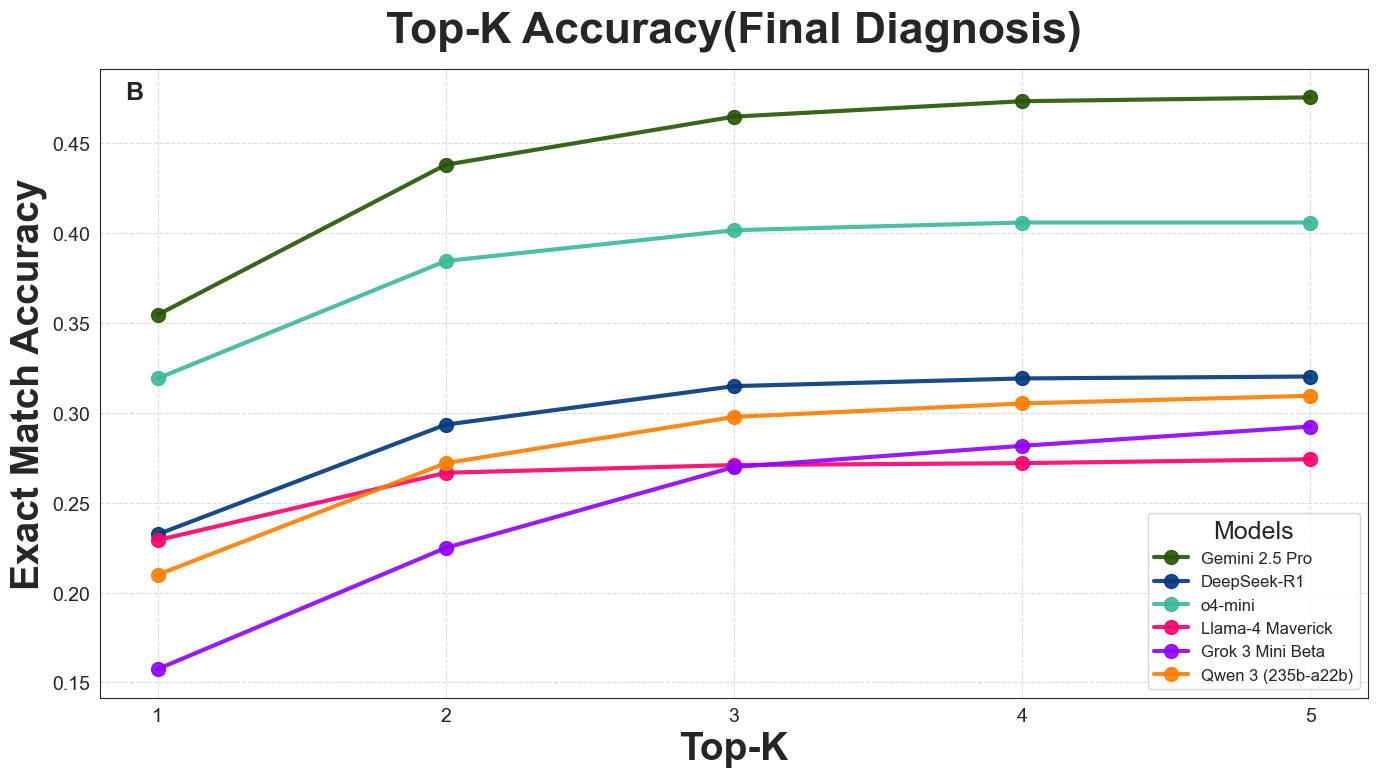

In [45]:
# Create figure for top-k accuracy comparison
plt.figure(figsize=(14, 8))
fig, ax = plt.subplots(figsize=(14, 8))

# Set style
sns.set_style("whitegrid")

# Top-k values to plot
k_values = [1, 2, 3, 4, 5]

# For each model
for ix, row in sum_stats.iterrows():    
    # Get accuracy values for final diagnosis
    accuracy_values = [
        row[f'final_top{k}_exact'] for k in k_values
    ]
    
    # Plot line
    plt.plot(k_values, accuracy_values, marker='o', linewidth=3, 
             color=model_colors[ix], alpha=0.9, label=model_name[ix], markersize=10)

# Add labels and title
plt.xlabel('Top-K', fontsize=28, fontweight='bold')
plt.ylabel('Exact Match Accuracy', fontsize=28, fontweight='bold')
plt.title('Top-K Accuracy(Final Diagnosis)', 
          fontsize=32, fontweight='bold', pad=20)

# Set x-ticks to integers
plt.xticks(k_values)

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend(frameon=True, fontsize=12, title="Models", title_fontsize=18)

# Add annotations
plt.text(0.02, 0.98, 'B', transform=ax.transAxes, fontsize=18, fontweight='bold',
         va='top', ha='left', bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, pad=0.1))

plt.tight_layout()
plt.savefig('topk_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [337]:
sum_stats.filter(like='final')

,confidence_value_final,confidence_value_final_approx_exact,confidence_value_final_exact,confidence_value_final_unmatched,final_confidence_score,final_top1_approx,final_top1_exact,final_top2_approx,final_top2_exact,final_top3_approx,final_top3_exact,final_top4_approx,final_top4_exact,final_top5_approx,final_top5_exact
gemini,0.768822,0.625449,0.395082,0.293110,0.370797,0.746253,0.354390,0.780514,0.437901,0.791221,0.464668,0.794433,0.473233,0.796574,0.475375
deepseek,0.586261,0.459600,0.231324,0.212405,0.353307,0.705567,0.232334,0.736617,0.293362,0.744111,0.314775,0.747323,0.319058,0.748394,0.320128
gpt,0.782100,0.614151,0.343210,0.240915,0.437859,0.738758,0.319058,0.766595,0.384368,0.774090,0.401499,0.776231,0.405782,0.776231,0.405782
llama,0.699524,0.513490,0.213089,0.224690,0.369747,0.699143,0.229122,0.710921,0.266595,0.710921,0.270878,0.711991,0.271949,0.713062,0.274090
grok,0.355646,0.272486,0.146529,0.141691,0.257325,0.644540,0.157388,0.679872,0.224839,0.699143,0.269807,0.707709,0.281585,0.714133,0.292291
qwen,0.470861,0.362311,0.194656,0.177851,0.291708,0.682013,0.209850,0.704497,0.271949,0.715203,0.297645,0.717345,0.305139,0.720557,0.309422


<Figure size 1400x800 with 0 Axes>

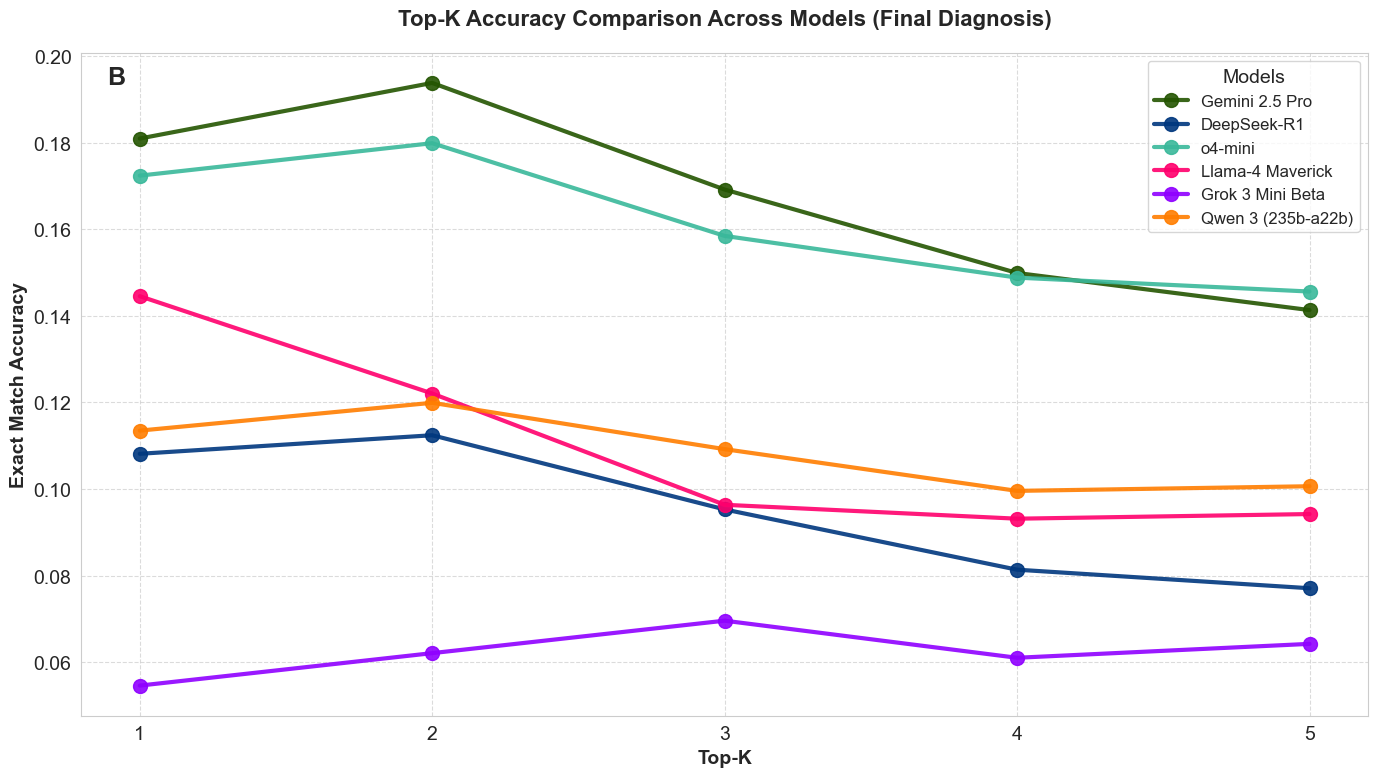

In [46]:
# Create figure for top-k accuracy comparison
plt.figure(figsize=(14, 8))
fig, ax = plt.subplots(figsize=(14, 8))

# Set style
sns.set_style("whitegrid")

# Top-k values to plot
k_values = [1, 2, 3, 4, 5]

# For each model
for ix, row in sum_stats.iterrows():    
    # Get accuracy values for final diagnosis
    accuracy_values = [
        row[f'final_top{k}_exact'] -  row[f'provisional_top{k}_exact']for k in k_values
    ]
    
    # Plot line
    plt.plot(k_values, accuracy_values, marker='o', linewidth=3, 
             color=model_colors[ix], alpha=0.9, label=model_name[ix], markersize=10)
    

# # For each model
# for ix, row in sum_stats.iterrows():    
#     # Get accuracy values for final diagnosis
#     accuracy_values = [
#         row[f'provisional_top{k}_exact'] for k in k_values
#     ]
    
#     # Plot line
#     plt.plot(k_values, accuracy_values, marker='o', linewidth=3, 
#              color=model_colors[ix], alpha=0.9, label=model_name[ix], markersize=10)

# Add labels and title
plt.xlabel('Top-K', fontsize=14, fontweight='bold')
plt.ylabel('Exact Match Accuracy', fontsize=14, fontweight='bold')
plt.title('Top-K Accuracy Comparison Across Models (Final Diagnosis)', 
          fontsize=16, fontweight='bold', pad=20)

# Set x-ticks to integers
plt.xticks(k_values)

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend(frameon=True, fontsize=12, title="Models", title_fontsize=14)

# Add annotations
plt.text(0.02, 0.98, 'B', transform=ax.transAxes, fontsize=18, fontweight='bold',
         va='top', ha='left', bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, pad=0.1))

plt.tight_layout()
plt.savefig('topk_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


0.5668736616702356
0.5097002141327623
0.5449036402569593
0.49152034261241967
0.4802783725910065
0.49601713062098507


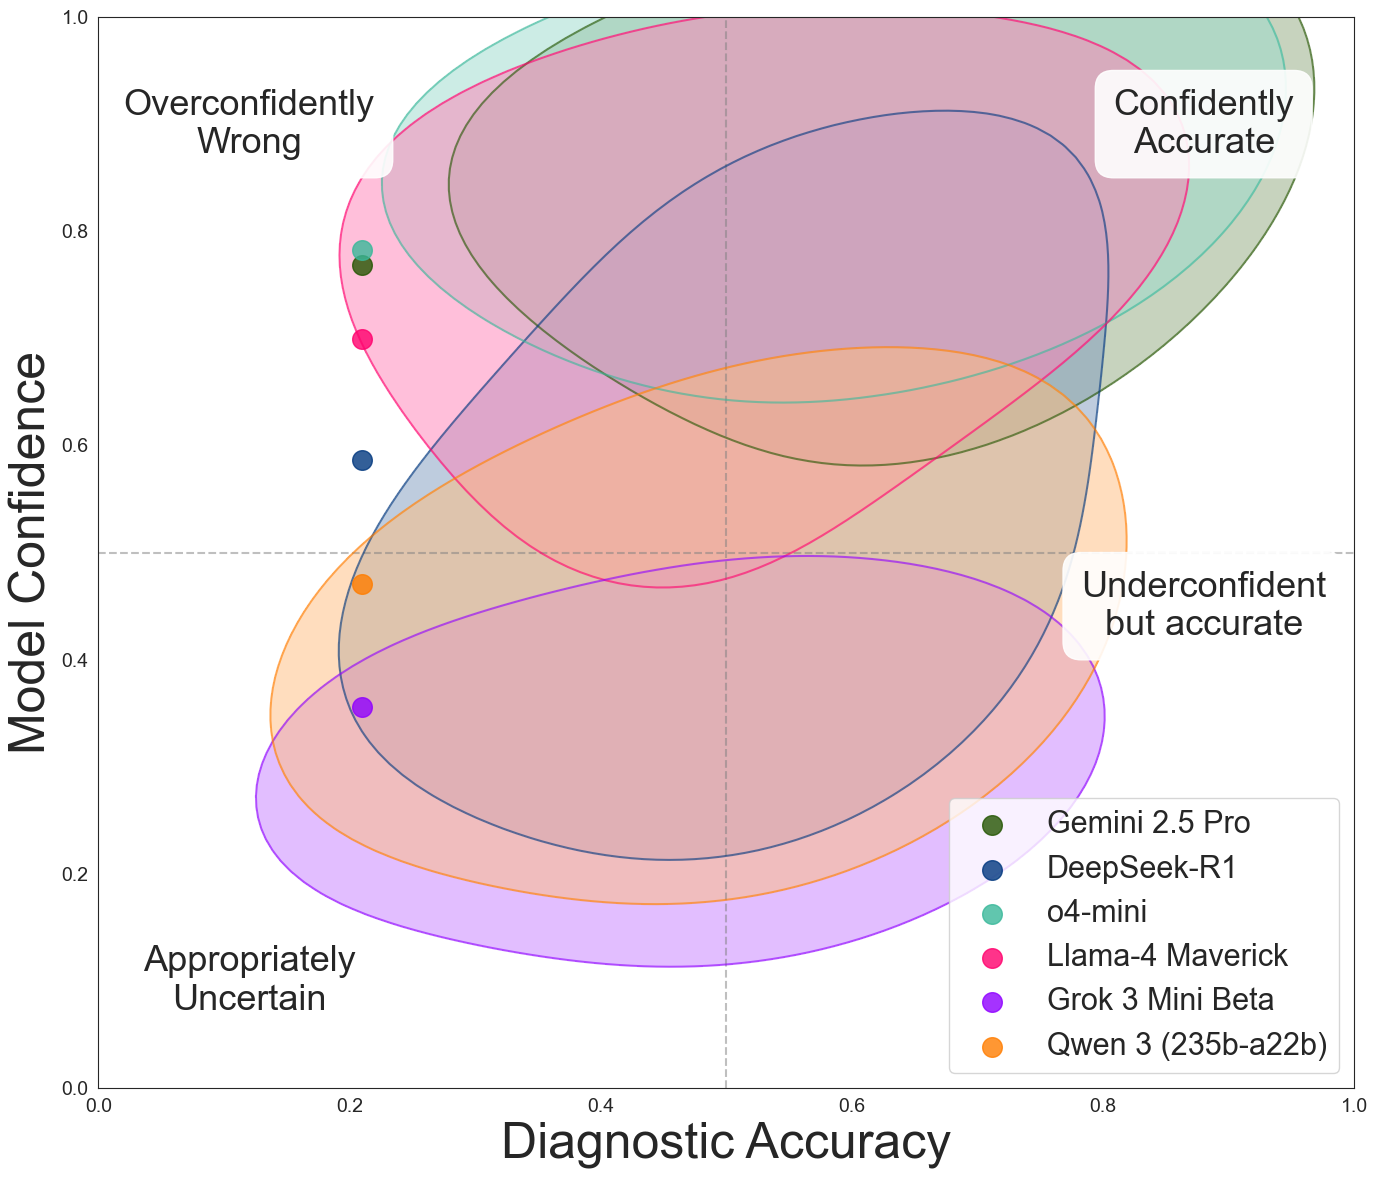

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

# Create the figure
fig, ax = plt.subplots(figsize=(14, 12))

sns.set_style("white")


# Collect all values first to determine plot bounds dynamically
accuracy_vals = []
confidence_vals = []

for model, model_data in all_results.items():
    # Extract accuracy and confidence values
    accuracy = model_data['final_top1_approx'].values
    confidence = model_data['confidence_value_final'].values
    
    accuracy_vals.extend(accuracy)
    confidence_vals.extend(confidence)

# Set bounds with some padding
x_min = 0
x_max = 1
y_min = 0
y_max = 1

# Use midpoints for quadrant lines
x_mid = (x_min + x_max) / 2
y_mid = (y_min + y_max) / 2

plt.axhline(y=y_mid, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)
plt.axvline(x=x_mid, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)

# Create a meshgrid for density plotting
xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# For legend creation
legend_elements = []

BW = 0.8
D = 0.5

# For each model, create KDE plot with adjusted bandwidth
for model, model_data in all_results.items():
    accuracy = model_data.filter(like='final_top').replace({1: 0.8, 0: 0.2}).mean(axis=1)
    # _accuracy = model_data.filter(regex='final_top[1]_exact').mean(axis=1)
    # accuracy = model_data.filter(regex='final_top[1]_exact').replace({1: 0.8, 0: 0.2}).mean(axis=1)
    # accuracy = model_data.filter(regex='final_top[1-3]_exact').replace({1: 0.8, 0: 0.2}).mean(axis=1)
    # accuracy = model_data.filter(regex='final_top[1-5]').mean(axis=1).replace({1: 0.75, 0: 0.25})
    print(np.mean(accuracy))
    confidence = model_data['confidence_value_final']
    df = pd.DataFrame({"accuracy": accuracy, "confidence": confidence})
    
    accuracy = df.accuracy.values
    confidence = df.confidence.values
    
    # Skip if we don't have enough data points
    if len(accuracy) < 5:
        continue
    
    # Create kernel density estimate with smaller bandwidth for tighter contours
    try:
        values = np.vstack([accuracy, confidence])
        # Use a smaller bandwidth factor to make the KDE more concentrated
        kernel = gaussian_kde(values, bw_method=BW)
        
        # Evaluate kernel on grid
        z = np.reshape(kernel(positions), xx.shape)
        
        # Find contour level that captures central 50% of the density mass
        sorted_z = np.sort(z.flatten())
        cumsum_z = np.cumsum(sorted_z) / np.sum(sorted_z)
        idx_50 = np.searchsorted(cumsum_z, D)
        density_threshold = sorted_z[idx_50]
        
        # Create custom colormap that goes from white to model color
        colors = [(1, 1, 1, 0), model_colors[model]]  # Start transparent
        cmap = LinearSegmentedColormap.from_list(f"Custom_{model}", colors, N=100)
        
        # Plot limited contours - focusing on the central mass
        contour = ax.contourf(xx, yy, z, 
                            levels=[density_threshold, z.max()], 
                            cmap=cmap, alpha=0.5)
        
        # Add a single contour line to delineate the blob boundary
        ax.contour(xx, yy, z, levels=[density_threshold], colors=[model_colors[model]], 
                  alpha=0.6, linewidths=1.5)
        
        # Add to legend
        legend_elements.append(Patch(facecolor=model_colors[model], alpha=0.6, 
                                    edgecolor=model_colors[model], label=model_name[model]))
    except:
        # Fallback if KDE fails
        print(f"KDE failed for {model}, falling back to simpler visualization")
    # Plot the mean point
    ax.scatter(
        np.mean(_accuracy), 
        np.mean(confidence),
        color=model_colors[model],
        s=200,
        label=model_name[model],
        alpha=0.8,
        zorder=100
        )
# Labels and title
plt.xlabel('Diagnostic Accuracy', fontsize=36)
plt.ylabel('Model Confidence', fontsize=36)
# plt.title('Confidence vs. Accuracy', fontsize=32, fontweight='bold', pad=20)

xrange = x_max - x_min
yrange = y_max - y_min

left = x_min + xrange * 0.12
right = x_min + xrange * 0.88
up = y_min + yrange * 0.9
down = y_min + yrange * 0.1

# Add quadrant labels
ax.text(left, up, 'Overconfidently\nWrong', 
        ha='center', va='center', fontsize=26, 
        bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.5'))
ax.text(right, up, 'Confidently\nAccurate', 
        ha='center', va='center', fontsize=26, 
        bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.5'))
ax.text(right, 0.45, 'Underconfident\nbut accurate', 
        ha='center', va='center', fontsize=26, 
        bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.5'))
ax.text(left, down, 'Appropriately\nUncertain', 
        ha='center', va='center', fontsize=26, 
        bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.5'))

# ax.set_xticklabels([])
# ax.set_yticklabels([])
# Set axis limits
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Add legend in a good position
ax.legend(fontsize=22, loc='lower right')

plt.tight_layout()
plt.savefig('confidence_accuracy_blob_focused.png', dpi=300, bbox_inches='tight')
plt.show()


In [227]:
list(gemini.keys())

['uid',
 'action_count',
 'hx_count',
 'phys_count',
 'ix_count',
 'img_count',
 'action_limit_reached',
 'hx_reached',
 'phys_reached',
 'ix_reached',
 'img_reached',
 'matched_keys',
 'unmatched_case_keys',
 'unmatched_request_keys',
 'provisional_diagnosis',
 'final_diagnosis',
 'agent_token_usage',
 'full_info_diagnosis',
 'final_top1_exact',
 'final_top1_approx',
 'final_top2_exact',
 'final_top2_approx',
 'final_top3_exact',
 'final_top3_approx',
 'final_top4_exact',
 'final_top4_approx',
 'final_top5_exact',
 'final_top5_approx',
 'final_confidence_score',
 'provisional_top1_exact',
 'provisional_top1_approx',
 'provisional_top2_exact',
 'provisional_top2_approx',
 'provisional_top3_exact',
 'provisional_top3_approx',
 'provisional_top4_exact',
 'provisional_top4_approx',
 'provisional_top5_exact',
 'provisional_top5_approx',
 'provisional_confidence_score',
 'full_info_top1_exact',
 'full_info_top1_approx',
 'full_info_top2_exact',
 'full_info_top2_approx',
 'full_info_top3_exa

In [277]:
sum_stats.filter(like="confidence")

,confidence_score_change,confidence_shifts,confidence_value_final,confidence_value_final_approx_exact,confidence_value_final_exact,confidence_value_final_unmatched,confidence_value_full_info,confidence_value_full_info_approx_exact,confidence_value_full_info_exact,confidence_value_full_info_unmatched,confidence_value_provisional,confidence_value_provisional_approx_exact,confidence_value_provisional_exact,confidence_value_provisional_unmatched,final_confidence_score,full_info_confidence_score,provisional_confidence_score
gemini,0.119617,0.095202,0.768822,0.625449,0.395082,0.293110,0.906466,0.896766,0.799373,0.889347,0.452809,0.338588,0.181183,0.422072,0.370797,0.544273,0.251180
deepseek,0.131943,0.123691,0.586261,0.459600,0.231324,0.212405,0.758937,0.760317,0.672067,0.674929,0.328930,0.236828,0.100393,0.317337,0.353307,0.597382,0.220639
gpt,0.182208,0.124187,0.782100,0.614151,0.343210,0.240915,0.850552,0.842899,0.717109,0.774056,0.382615,0.276556,0.124688,0.345494,0.437859,0.694954,0.247997
llama,0.174014,0.050915,0.699524,0.513490,0.213089,0.224690,0.773454,0.758428,0.577536,0.681054,0.487494,0.312131,0.081156,0.475746,0.369747,0.702777,0.195733
grok,0.055959,0.003070,0.355646,0.272486,0.146529,0.141691,0.702367,0.705131,0.613621,0.561138,0.303594,0.219738,0.093549,0.280789,0.257325,0.689979,0.201366
qwen,0.076700,0.073674,0.470861,0.362311,0.194656,0.177851,0.566916,0.604552,0.511572,0.467831,0.289675,0.212782,0.085885,0.298408,0.291708,0.526661,0.197303


In [278]:
sum_stats['total_change_magnitude']

gemini      0.189368
deepseek    0.242892
gpt         0.203395
llama       0.167612
grok        0.415557
qwen        0.271532
Name: total_change_magnitude, dtype: float64

In [285]:
sum_stats.filter(like="recall")

,hp_all_recall,hp_matched_recall,ix_all_recall,ix_matched_recall
gemini,0.411043,0.344857,0.286445,0.308815
deepseek,0.276091,0.222036,0.219367,0.225083
gpt,0.333840,0.289529,0.295490,0.314433
llama,0.315270,0.243923,0.238236,0.250329
grok,0.378413,0.283561,0.146287,0.148048
qwen,0.333701,0.260470,0.215653,0.231208


In [50]:
# offset for radar chart
offset = 0.39269908169872414

[0.27190668152927255, 0.3448569359265437, 0.44762046186029053, 0.41104272662224883, 0.4919462425515275, 0.28644547523093916, 0.32582896092232544, 0.3088146484608461]
[0.2972944495428435, 0.22203559019009556, 0.5655056993922091, 0.27609056996108455, 0.44981437556616055, 0.2193669137278218, 0.2530045565232451, 0.2250828476102523]
[0.321102719550257, 0.2895289056923713, 0.5619457065656209, 0.33383971405130775, 0.5004035312124999, 0.2954902064143069, 0.2959689265519372, 0.3144329349331565]
[0.3376608313171483, 0.24392278184943142, 0.6772001909582208, 0.31526992857052144, 0.5173380385252074, 0.23823609685019723, 0.27156489214981266, 0.2503293140563407]
[0.23975013209488583, 0.28356086245866996, 0.5125312559199069, 0.37841280898978524, 0.4679183949526562, 0.1462872740983495, 0.24151699181142436, 0.14804765424562097]
[0.2842897080316781, 0.260470340795225, 0.5675471833662412, 0.3337012899420807, 0.4738641587365899, 0.21565298078082465, 0.26200567849163847, 0.23120828420748885]


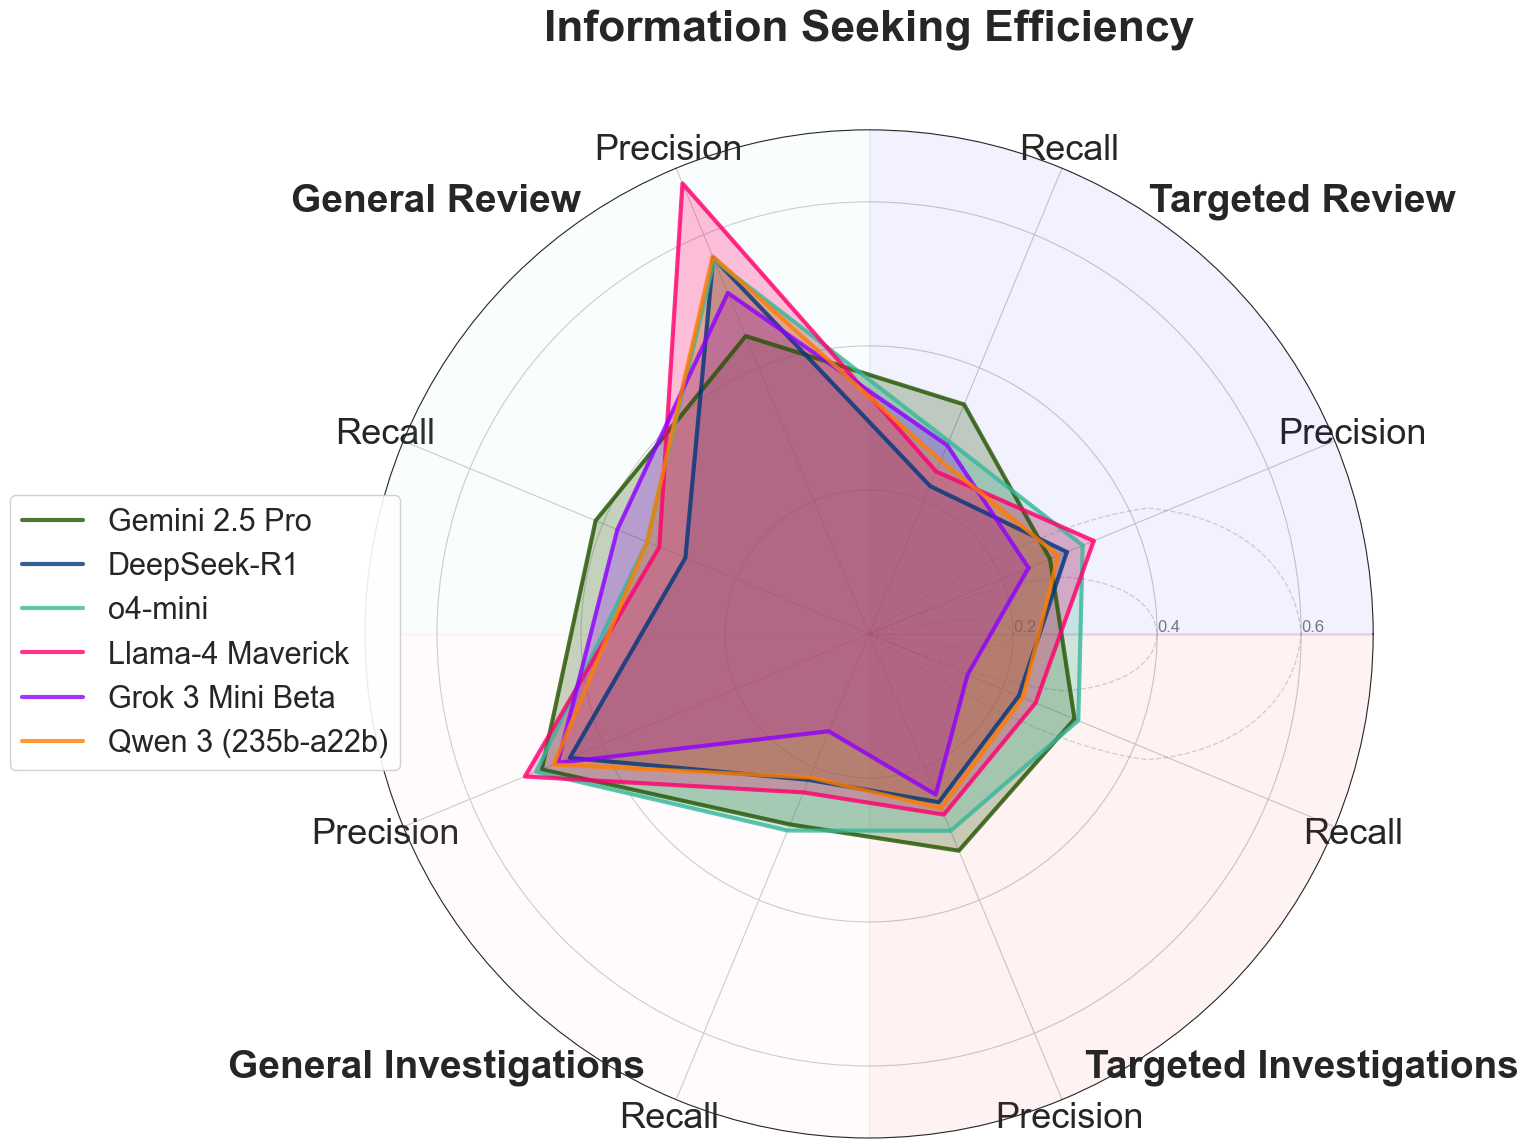

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

# Function to create a radar chart
def radar_chart(ax, angles, values, color, label, alpha=0.25, linewidth=2):
    # Close the plot
    values = np.append(values, values[0])
    
    # Plot data
    ax.plot(angles, values, '-', linewidth=linewidth, color=color,  label=model_name[label], alpha=0.8)
    
    # Fill area
    ax.fill(angles, values, color=color, alpha=alpha)

# Create figure
fig, ax = plt.subplots(figsize=(14, 12), subplot_kw=dict(polar=True))

# Set style to pure white
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 14
})
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Simplify category labels
categories = ['Precision', 'Recall', 'Precision', 'Recall', 
              'Precision', 'Recall', 'Precision', 'Recall']

# Number of categories
N = len(categories)

# Calculate angles for each axis
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles = [a + offset for a in angles]
angles += angles[:1]  # Close the loop

# Set the label positions
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=26)

# # Draw concentric circles for reference
circle_positions = [0.2, 0.4, 0.6]
for circle_pos in circle_positions:
    circle = plt.Circle((0, 0), circle_pos, fill=False, color='grey', alpha=0.3, linestyle='--')
    ax.add_patch(circle)

# Draw y-axis labels
ax.set_rlabel_position(0)
plt.yticks(circle_positions, [f"{pos:.1f}" for pos in circle_positions], 
           fontsize=12, color="grey")
plt.ylim(0, 0.7)  # Set range limit

# # Add grid lines (more subtle)
# ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.2)

# Instead of wedges, let's add shaded background regions using filled polygons
# For each quadrant, create custom background

# Define the quadrants (in radians)
# HP Matched: 0-pi/2
hp_matched_angles = np.linspace(0, np.pi/2, 100)
hp_matched_radii = [0.7] * len(hp_matched_angles)
ax.fill_between(hp_matched_angles, 0, hp_matched_radii, alpha=0.05, color='blue')

# HP All: pi/2-pi
hp_all_angles = np.linspace(np.pi/2, np.pi, 100)
hp_all_radii = [0.7] * len(hp_all_angles)
ax.fill_between(hp_all_angles, 0, hp_all_radii, alpha=0.05, color='lightblue')

# IX All: pi-3pi/2
ix_all_angles = np.linspace(np.pi, 3*np.pi/2, 100)
ix_all_radii = [0.7] * len(ix_all_angles)
ax.fill_between(ix_all_angles, 0, ix_all_radii, alpha=0.05, color='pink')

# IX Matched: 3pi/2-2pi
ix_matched_angles = np.linspace(3*np.pi/2, 2*np.pi, 100)
ix_matched_radii = [0.7] * len(ix_matched_angles)
ax.fill_between(ix_matched_angles, 0, ix_matched_radii, alpha=0.05, color='red')


# Add plots for each model
for model, model_data in list(all_results.items()):
    # Extract metrics
    values = [
        model_data['hp_matched_precision'].mean(),
        model_data['hp_matched_recall'].mean(),
        model_data['hp_all_precision'].mean(),
        model_data['hp_all_recall'].mean(),
        model_data['ix_all_precision'].mean(),
        model_data['ix_all_recall'].mean(),
        model_data['ix_matched_precision'].mean(),
        model_data['ix_matched_recall'].mean(),
    ]
    
    print(values)
    
    # Plot the individual model
    radar_chart(ax, angles, values, model_colors[model], model, linewidth=3)

# Add section labels at appropriate angles
# Text in polar coordinates needs (radius, angle)
ax.text(np.pi/4 , 0.85, "Targeted Review", fontsize=28, ha='center', va='center', weight='bold', zorder=100)
ax.text(3*np.pi/4 , 0.85, "General Review", fontsize=28, ha='center', va='center', weight='bold', zorder=100)
ax.text(5*np.pi/4 , 0.85, "General Investigations", fontsize=28, ha='center', va='center', weight='bold', zorder=100)
ax.text(7*np.pi/4 , 0.85, "Targeted Investigations", fontsize=28, ha='center', va='center', weight='bold', zorder=100)

# Add legend with better positioning and larger font
plt.legend(loc='lower right', bbox_to_anchor=(0.05, 0.35), fontsize=22, 
           frameon=True, framealpha=0.9)

# Add title
plt.title('Information Seeking Efficiency', size=32, fontweight='bold', y=1.08)

# # Add figure label
# plt.text(0.02, 0.98, 'C', transform=fig.transFigure, fontsize=20, fontweight='bold',
#          va='top', ha='left', bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, pad=0.1))

plt.tight_layout()
plt.savefig('information_seeking_radar.png', dpi=300, bbox_inches='tight')
plt.show()


In [214]:
# accuracy = model_data.filter(like='provisional_top').join(model_data.filter(like='final_top')).mean(axis=1)
accuracy = model_data.filter(like='final_top').mean(axis=1)

# confidence = model_data['confidence_value_final'] + model_data['confidence_value_provisional'] / 2
confidence = model_data['confidence_value_final']
df = pd.DataFrame({"accuracy": accuracy, "confidence": confidence})
df[df['accuracy'] != 0]

,accuracy,confidence
uid,,
31179908,0.9,0.866667
25505728,1.0,0.800000
38738098,0.5,0.950000
35283574,0.5,0.780000
32595435,0.5,0.750000
...,...,...
34430034,0.8,0.275000
36475216,1.0,0.633333
28948030,1.0,0.720000


In [430]:
rows = {}
for ix, df in all_results.items():
    __df = ds.join(df, lsuffix='_').groupby('specialty_group').mean(numeric_only=True)
    rows[ix] = __df['final_top1_exact']

In [467]:
ds.join(df, lsuffix='_').query("specialty_group == 'Respiratory'")

,source,vignette,specialty_group,diagnosis,differentials,clinicalcase,accuracy,confidence
uid,,,,,,,,
37503648,PubMed,Title: An Important Clinical Condition in Diff...,Respiratory,['Crack lung (acute pulmonary toxicity due to ...,"['Atypical pneumonia', 'Acute respiratory dist...","{""history_freetext"": ""The patient experienced ...",0.5,0.333333
38161857,PubMed,Title: Chronic Eosinophilic Pneumonia: Unravel...,Respiratory,['Chronic eosinophilic pneumonia'],[],"{""history_freetext"": ""Over the past month, the...",0.5,0.500000
29147472,PubMed,Title: Recurrent dyspnea and wheezing- pulmona...,Respiratory,['Tracheobronchomalacia'],['Chronic Obstructive Pulmonary Disease'],"{""history_freetext"": ""Over the past month, the...",0.5,0.600000
34430034,PubMed,Title: Low-dose oestrogen–progestin associated...,Respiratory,"['Acute pulmonary embolism', 'Pulmonary infarc...",['Community-acquired pneumonia'],"{""history_freetext"": ""Over the past two weeks,...",0.8,0.275000
32709679,PubMed,Title: Vital corner of diagnostic challenge: e...,Respiratory,['Eosinophilic granulomatosis with polyangiitis'],['Acute eosinophilic pneumonia'],"{""history_freetext"": ""The patient had been exp...",0.5,0.500000
34221774,PubMed,Title: A Nearly Missed Pancoast Tumour From Is...,Respiratory,['Pancoast tumour (Superior sulcus non–small c...,[],"{""history_freetext"": ""The patient reports a on...",0.0,0.250000
37886359,PubMed,Title: Acute abdominal pain as the first sympt...,Respiratory,"['Psittacosis (Chlamydia psittaci) pneumonia',...",[],"{""history_freetext"": ""Over several days, the p...",1.0,0.900000
29147401,PubMed,Title: Another Case of Pulmonary Edema or May ...,Respiratory,['Secondary malignant neoplasm of lung (metast...,['Lymphangitic carcinomatosis (from metastatic...,"{""history_freetext"": ""Over the past two weeks,...",0.5,0.725000
36686202,PubMed,Title: A Case of Previously Undiagnosed System...,Respiratory,['Systemic lupus erythematosus with organ or s...,[],"{""history_freetext"": ""The patient reports two ...",0.5,0.250000


In [465]:
__df

,action_count,hx_count,phys_count,ix_count,img_count,action_limit_reached,hx_reached,phys_reached,ix_reached,img_reached,...,diagnoses_removed,diagnoses_maintained,exact_accuracy_change,approx_accuracy_change,confidence_score_change,confidence_shifts,total_change_magnitude,confidence_value_full_info_unmatched,confidence_value_provisional_unmatched,confidence_delta
specialty_group,,,,,,,,,,,,,,,,,,,,,
Cardiovascular & Metabolic,5.335664,1.034965,0.818182,0.937063,0.622378,0.0,0.0,0.0,0.0,0.0,...,2.446970,1.348485,0.113636,0.060606,0.065744,0.095145,0.273485,0.547899,0.334435,0.208885
Endocrine & Reproductive,5.233577,1.014599,0.744526,1.072993,0.540146,0.0,0.0,0.0,0.0,0.0,...,2.762712,1.211864,0.169492,0.076271,0.103066,0.077352,0.273898,0.507108,0.290125,0.206736
Gastrointestinal,5.669118,1.058824,0.808824,0.970588,0.970588,0.0,0.0,0.0,0.0,0.0,...,2.760684,1.264957,0.119658,0.059829,0.094108,0.080812,0.263077,0.478702,0.310173,0.182162
Gynecological / Reproductive,6.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,...,3.000000,1.000000,0.000000,0.000000,0.000000,0.200000,0.200000,NaN,NaN,0.516667
Hematology / Oncology / Other,5.587156,1.036697,0.743119,1.000000,0.908257,0.0,0.0,0.0,0.0,0.0,...,2.693878,1.448980,0.061224,0.061224,0.072110,0.061097,0.247449,0.527037,0.264187,0.160773
Infectious Disease & Immunology,5.621622,1.040541,0.831081,0.966216,0.885135,0.0,0.0,0.0,0.0,0.0,...,2.578947,1.308271,0.060150,0.022556,0.039585,0.072669,0.266541,0.410944,0.294153,0.157706
Musculoskeletal & Pain,5.916667,1.000000,0.833333,0.916667,1.250000,0.0,0.0,0.0,0.0,0.0,...,1.904762,1.714286,0.047619,0.047619,-0.045743,0.005000,0.285714,0.431061,0.306061,0.114757
Neurological / Psychiatric,5.264000,1.008000,0.752000,0.688000,0.936000,0.0,0.0,0.0,0.0,0.0,...,2.185185,1.444444,0.120370,0.037037,0.088722,0.055394,0.307870,0.358778,0.262581,0.194073
Pediatric,5.476190,1.000000,0.825397,0.952381,0.857143,0.0,0.0,0.0,0.0,0.0,...,2.735849,1.207547,0.207547,0.094340,0.137069,0.087264,0.255660,0.425546,0.318368,0.195486


In [433]:
spec = pd.DataFrame(rows)

In [438]:
spec = spec.drop('Gynecological / Reproductive', axis=0)

In [439]:
spec

,gemini,deepseek,gpt,llama,grok,qwen
specialty_group,,,,,,
Cardiovascular & Metabolic,0.335664,0.188811,0.307692,0.209790,0.139860,0.188811
Endocrine & Reproductive,0.474453,0.270073,0.416058,0.233577,0.204380,0.270073
Gastrointestinal,0.338235,0.257353,0.389706,0.279412,0.183824,0.227941
Hematology / Oncology / Other,0.220183,0.229358,0.247706,0.165138,0.119266,0.155963
Infectious Disease & Immunology,0.290541,0.222973,0.229730,0.202703,0.081081,0.155405
Musculoskeletal & Pain,0.375000,0.333333,0.250000,0.250000,0.083333,0.125000
Neurological / Psychiatric,0.456000,0.288000,0.384000,0.304000,0.256000,0.256000
Pediatric,0.396825,0.126984,0.206349,0.238095,0.142857,0.301587
Respiratory,0.270833,0.145833,0.333333,0.125000,0.104167,0.125000


In [ ]:
# One-liner using numpy percentile
import numpy as np
middle_50_pct = df[(df['accuracy'] >= np.percentile(df['accuracy'], 25)) & 
                   (df['accuracy'] <= np.percentile(df['accuracy'], 75))]



,accuracy,confidence
uid,,
31179908,0.9,0.866667
25505728,1.0,0.800000
38738098,0.5,0.950000
35283574,0.5,0.780000
32595435,0.5,0.750000
...,...,...
34430034,0.8,0.275000
36475216,1.0,0.633333
28948030,1.0,0.720000


<Figure size 1400x800 with 0 Axes>

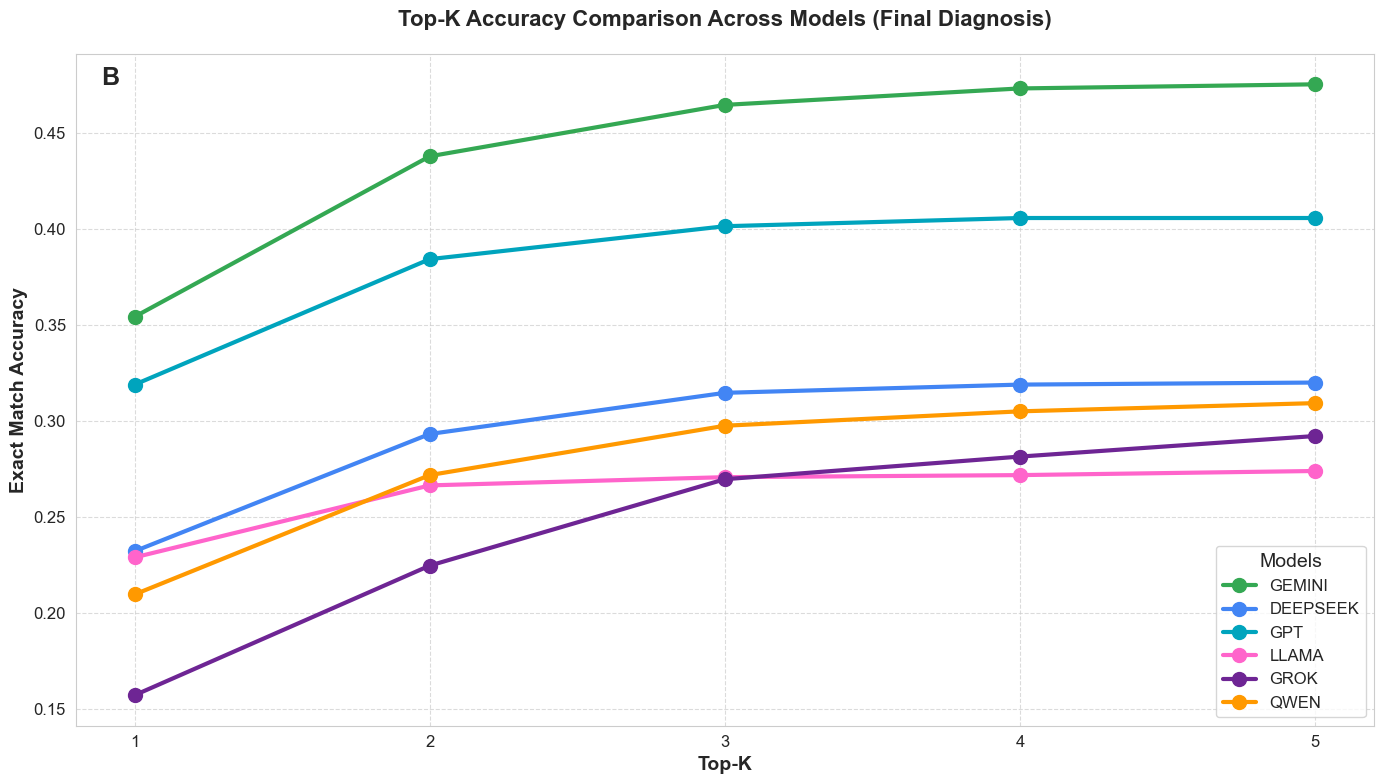

In [ ]:
# Create figure for top-k accuracy comparison
plt.figure(figsize=(14, 8))
fig, ax = plt.subplots(figsize=(14, 8))

# Set style
sns.set_style("whitegrid")

# Top-k values to plot
k_values = [1, 2, 3, 4, 5]

# For each model
for model, model_data in all_results.items():
    
    # Get accuracy values for final diagnosis
    accuracy_values = [
        model_data[f'final_top{k}_exact'].mean() for k in k_values
    ]
    
    # Plot line
    plt.plot(k_values, accuracy_values, marker='o', linewidth=3, 
             color=model_colors[model], label=model_name[model], markersize=10)

# Add labels and title
plt.xlabel('Top-K', fontsize=14, fontweight='bold')
plt.ylabel('Exact Match Accuracy', fontsize=14, fontweight='bold')
plt.title('Top-K Accuracy Comparison Across Models (Final Diagnosis)', 
          fontsize=16, fontweight='bold', pad=20)

# Set x-ticks to integers
plt.xticks(k_values)

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend(frameon=True, fontsize=12, title="Models", title_fontsize=14)

# Add annotations
plt.text(0.02, 0.98, 'B', transform=ax.transAxes, fontsize=18, fontweight='bold',
         va='top', ha='left', bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, pad=0.1))

plt.tight_layout()
plt.savefig('topk_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [460]:
values = spec.to_dict(orient='list')

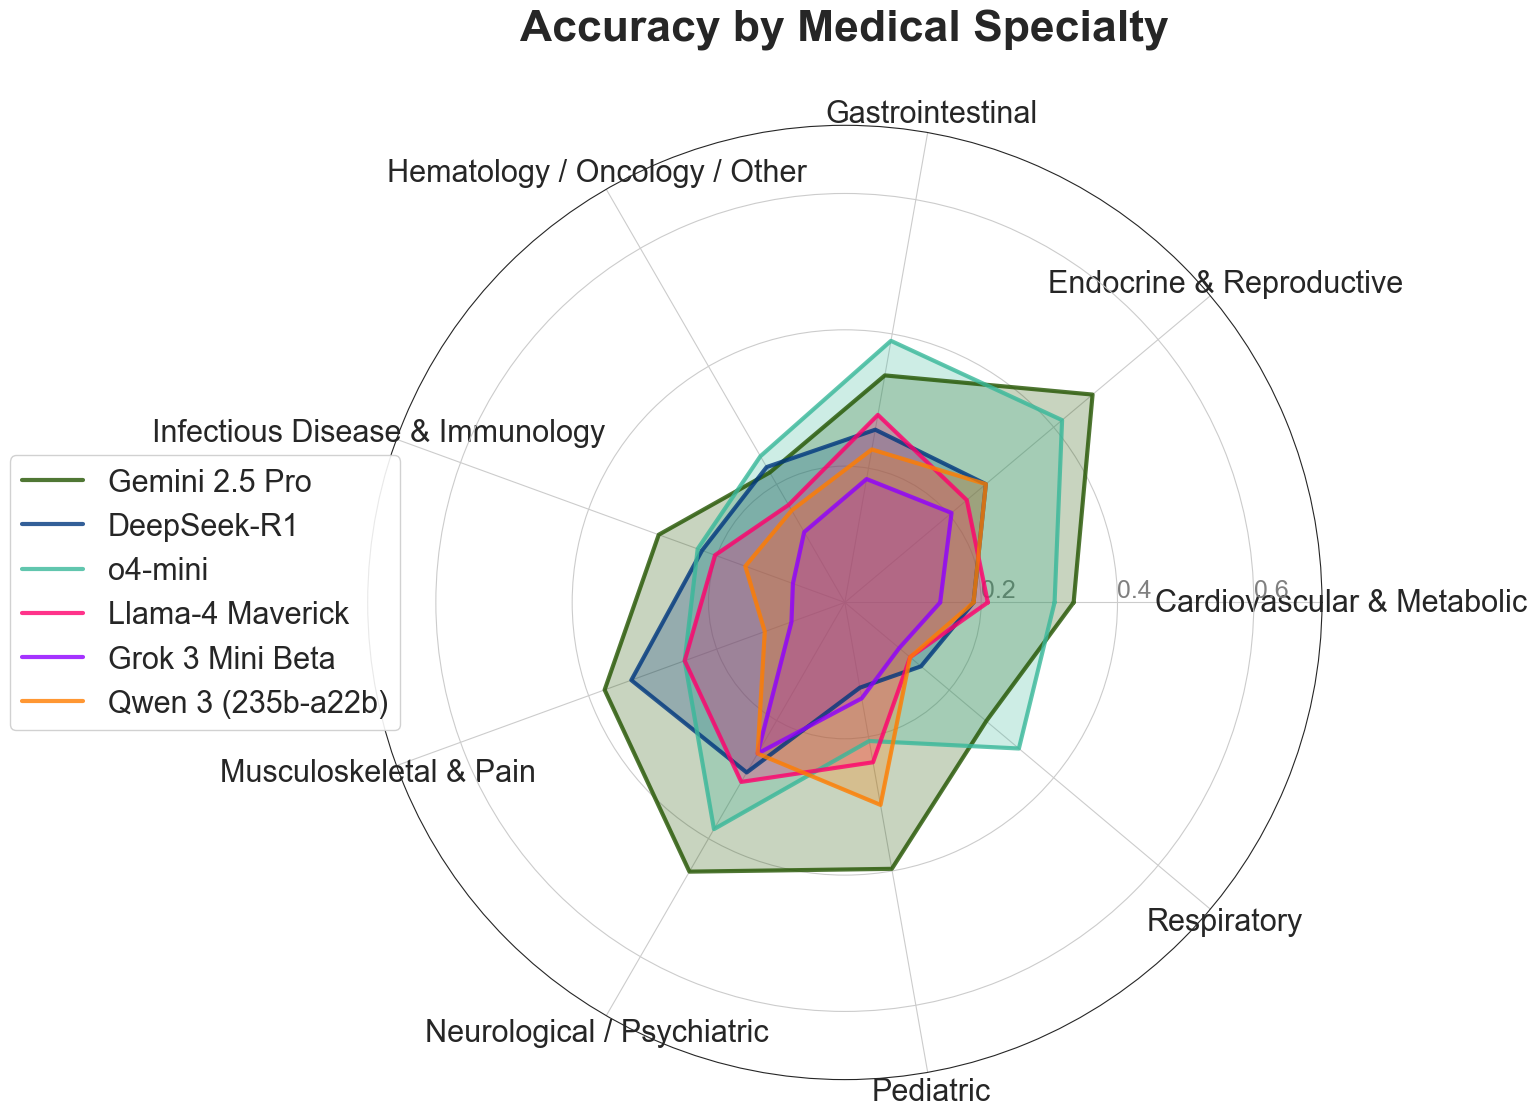

In [463]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

# Data from the specialty groups table
specialty_groups = [
    'Cardiovascular & Metabolic',
    'Endocrine & Reproductive',
    'Gastrointestinal',
    'Hematology / Oncology / Other',
    'Infectious Disease & Immunology',
    'Musculoskeletal & Pain',
    'Neurological / Psychiatric',
    'Pediatric',
    'Respiratory'
]

models = ['gemini', 'deepseek', 'gpt', 'llama', 'grok', 'qwen']



# Function to create a radar chart
def radar_chart(ax, angles, values, color, label, alpha=0.25, linewidth=2):
    # Close the plot
    values = np.append(values, values[0])
    
    # Plot data
    ax.plot(angles, values, '-', linewidth=linewidth, color=color, label=model_name[label], alpha=0.8)
    
    # Fill area
    ax.fill(angles, values, color=color, alpha=alpha)

# Create figure
fig, ax = plt.subplots(figsize=(14, 12), subplot_kw=dict(polar=True))

# Set style to pure white
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 14
})
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Number of categories
N = len(specialty_groups)

# Calculate angles for each axis
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Set the label positions
ax.set_xticks(angles[:-1])
ax.set_xticklabels(specialty_groups, fontsize=22)

# Draw y-axis labels
ax.set_rlabel_position(0)
circle_positions = [0.2, 0.4, 0.6]
plt.yticks(circle_positions, [f"{pos:.1f}" for pos in circle_positions], 
           fontsize=18, color="grey")
plt.ylim(0, 0.7)  # Set range limit

# Add plots for each model
for model in models:
    model_values = values[model]
    # Plot the individual model
    radar_chart(ax, angles, model_values, model_colors[model], model, linewidth=3)

# Add legend with better positioning and larger font
plt.legend(loc='lower right', bbox_to_anchor=(0.05, 0.35), fontsize=22, 
           frameon=True, framealpha=0.9)

# Add title
plt.title('Accuracy by Medical Specialty', size=32, fontweight='bold', y=1.08)

plt.tight_layout()
plt.savefig('specialty_performance_radar.png', dpi=300, bbox_inches='tight')
plt.show()
